In [2]:
import tensorflow as tf
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pickle
from collections import Counter
import json
import subprocess
import keras_hub

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-10-15 21:51:05.514438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-15 21:51:08.727619: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2.16.2
1 Physical GPUs, 1 Logical GPUs


2025-10-15 21:51:13.462877: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-15 21:51:13.462926: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-15 21:51:13.464078: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-15 21:51:13.464142: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-15 21:51:13.464167: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

## Approach  

Since the data we have is from the paper "Xie, N., Lai, F., Doran, D., & Kadav, A. (2019). Visual Entailment: A Novel Task for Fine-Grained Image Understanding. ArXiv, abs/1901.06706." I began by looking at their approach. As ilistraited below this modal first extracts feature data from the text and images using a combination of token embedding, RCNN and self attention, then attention is computed between the 2 encoded features that is fed through a MLP to generate the final output. This paper doesn't use transformers and was written before they became dominant in the text and image processing space so I decided I wanted to investigate trying to use transformers to encode the image and text features.       

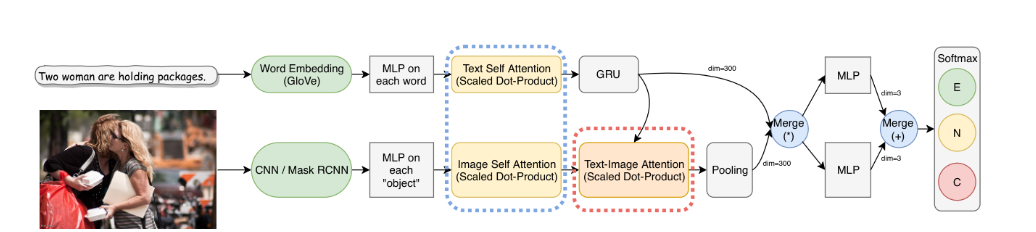

I found a paper "Hu, R., & Singh, A. (2021). UniT: Multimodal Multitask Learning with a Unified Transformer. 2021 IEEE/CVF International Conference on Computer Vision (ICCV), 1419-1429." that applied transformers to this task and leveraging transfer learning to better extract generalized features from image and text inputs. 

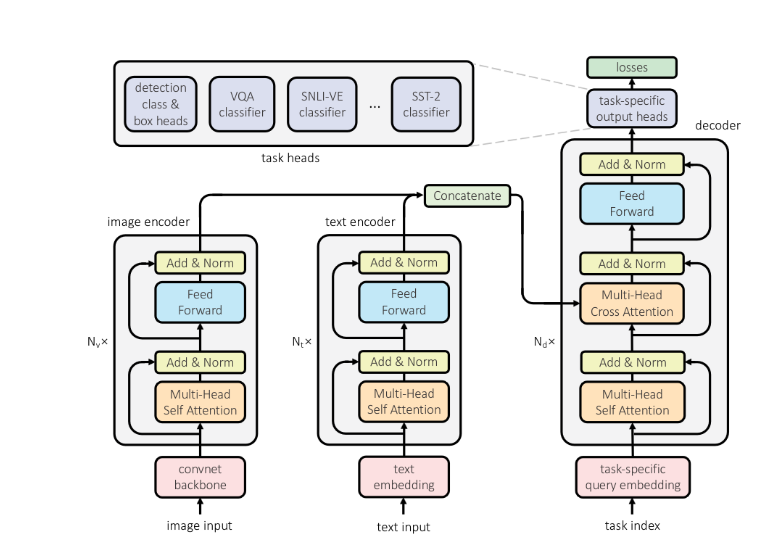

I decided that I would use transformers for feature extraction like the UniT paper but because I was only training the model for the one task I opted to use an MLP and attention combination similar to the Visual Entailment paper.    

## Exploring the data

I loaded all the training image names and their attached tokenized hypothesis and labels.

I printed out the size of the dataset and the ratio of entangled to contradictory images in the dataset as well as a random sample of images to get an idea of how the dataset looks. 

The ratio of entailment to contradiction appears to be close to 1 to 1 with on average one of each for every image this means that the dataset should be fairly balanced and I shouldn't need to augment the data to account for imbalance in training. 
On the other hand the images have differing resolutions that will require scaling to a common resolution for the model to be able to process correctly. 
Looking at the images there is a wide variety of lighting conditions, backgrounds, and resolutions this information will be useful for implementing data augmentation.   

Number of images 19573
Vocab length 9274
hypothesis count 39129
Dataset balance Counter({'entailment': 19619, 'contradiction': 19510})


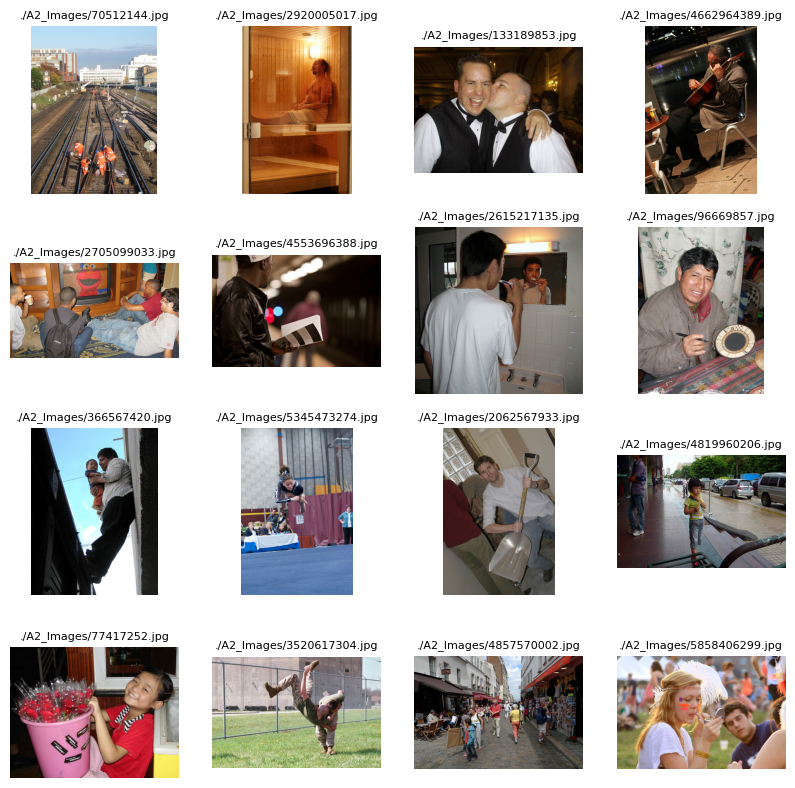

In [3]:
# load images and labels 

labelSet = Counter()
dataDict = {}
vocab = set()

datasetLen = 0
with open("./A2_train_v3.jsonl", "r") as jsonFile:
	for line in jsonFile:
		datasetLen += 1
		loadedLine = json.loads(line)
		if loadedLine["Image_ID"] not in dataDict:
			dataDict[loadedLine["Image_ID"]] = []

		labelSet[loadedLine["Label"]] += 1

		hypo = [''.join(char for char in word if char.isalnum()) for word in loadedLine["Hypothesis"].lower().split()]
		vocab.update(hypo)

		dataDict[loadedLine["Image_ID"]].append((hypo, loadedLine["Label"]))

labelTuple = tuple(labelSet.keys())
vocab = list(vocab)

vocabIndex = {vocab[i]: i for i in range(len(vocab))}

print(f'Number of images {len(dataDict.keys())}')
print(f'Vocab length {len(vocabIndex)}')
print(f'hypothesis count {datasetLen}')
print(f'Dataset balance {labelSet}')

gridSize = 4
plt.figure(figsize=(10, 10)) 

for i in range(gridSize ** 2):
	image_file = './A2_Images/' + random.choice(list(dataDict.keys())) + '.jpg'
	img = mpimg.imread(image_file)

	plt.subplot(gridSize, gridSize, i + 1)
	plt.imshow(img)
	plt.title(image_file, fontsize=8)
	plt.axis('off') # Hide axes for cleaner image display

plt.show()

## Word embeddings 

I used the glove pretrained embeddings for the text input because they have proved useful in capturing meaning of text in many other papers and they were trained on a far larger dataset of text than the one I have and therefor the embedings are morelikely to capture the true meaning of text tokens then any embeddings I can create.   


In [4]:
# load the glove embeddings 

def getGlove():
  print('Downloading glove')
  subprocess.run(['wget', 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'])
  subprocess.run(['unzip', '-q glove.6B.zip'])

def generateMatrix(dim):
    print('parsing glove data')
    embeddingMatrix = np.zeros((len(vocab), dim))
    embeddedVocab = []
    
    with open(f'glove.6B.{dim}d.txt', encoding="utf-8") as gloveFile:
      for line in gloveFile:
        values = line.split()
        word = values[0]
    
        if word in vocab:
          embeddingMatrix[vocabIndex[word]] = np.asarray(values[1:], dtype='float32')
          embeddedVocab.append(word)

    print(f'embedded {len(embeddedVocab)} out of {len(vocab)}')
    return embeddingMatrix, [i for i in vocab if i not in embeddedVocab]


embeddingDim = 200
embeddingMatrix = None
notEmbeddedVocab = None

if not os.path.isfile(f'glove.6B.{embeddingDim}d.txt'):
  getGlove()

if os.path.isfile(f'embeddingMatrix.{embeddingDim}d.pkl'):
  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'rb') as f:
    embeddingMatrix = pickle.load(f)

  print('loaded matrix')
else:
  embeddingMatrix, notEmbeddedVocab = generateMatrix(embeddingDim)

  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'ab') as f:
    pickle.dump(embeddingMatrix, f)

  print('saved matrix')

  print(len(notEmbeddedVocab))

loaded matrix


## Creating the dataset 

I chose to scale all the images down to a resolution of 224 by 224 because this is a resolution commonly used by imagenet (this fact will be important when I get the the model structure) it also makes the dataset smaller and easy to work with while not loosing too much information in the process.  

In [26]:
maxLen = 128
imageChannels = 3
imageRes = 224

X1array = []
X2array = []
YArray = []

for key, hypoAndLabels in dataDict.items():
	img = f'./A2_Images/{key}.jpg'

	for hypo, label in hypoAndLabels:
		label = tf.convert_to_tensor([labelTuple.index(label)])
		label.set_shape([1])

		hypo = [vocabIndex[word] for word in hypo]
		hypo = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([hypo], maxlen=maxLen)[0])
		hypo.set_shape([maxLen])

		X1array.append(img)
		X2array.append(hypo)
		YArray.append(label)

X1Numpy = np.array(X1array)
X2Numpy = np.array(X2array, dtype='uint16')
YNumpy = np.array(YArray, dtype='uint8')

dataset = tf.data.Dataset.from_tensor_slices(({'image': X1Numpy, 'text': X2Numpy}, YNumpy)) 

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_image(img, channels=imageChannels, dtype=tf.float32)
	img = tf.image.resize(img, (imageRes, imageRes))

	return img

def getImageWrapper(x, y):
	img = tf.py_function(func=getImage, inp=[x['image']], Tout=tf.float32)
	img.set_shape([imageRes, imageRes, imageChannels])

	x['image'] = img 
	return x, y

dataset = dataset.map(getImageWrapper, num_parallel_calls=8)

dataset.shuffle(5000)

testSize = int(datasetLen * 0.05)
valSize = int(datasetLen * 0.1)
trainSize = int(datasetLen - valSize - testSize)
batchSize = 100

def optimize(ds, name):
	ds = ds.batch(batchSize) 
	ds = ds.cache(name + 'dataset.cache') 
	ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
	
	return ds

def getTest(ds):
	ds = ds.take(testSize) 
	ds = optimize(ds, 'test')

	return ds

def getVal(ds):
	ds = ds.skip(testSize)
	ds = ds.take(valSize) 
	ds = optimize(ds, 'val')

	return ds

def getTrain(ds):
	ds = ds.skip(testSize + valSize)
	ds = ds.take(trainSize)
	ds = optimize(ds, 'train')

	return ds

testDS = getTest(dataset)
valDS = getVal(dataset)
trainDS = getTrain(dataset)

print(f"test data batches {tf.data.experimental.cardinality(testDS).numpy()}")
print(f"val data batches {tf.data.experimental.cardinality(valDS).numpy()}")
print(f"train data batches {tf.data.experimental.cardinality(trainDS).numpy()}")
print(f'ratios test:{testSize} val:{valSize} train:{trainSize}')


test data batches 20
val data batches 40
train data batches 333
ratios test:1956 val:3912 train:33261


In [25]:
# clear dataset cache

for f in os.listdir('./'):  
	if 'dataset.cache' in f:
		os.remove(f)

# The Model

I chose a target of 80% accuracy for this model, while 75% is fairly low this model is intended to rate how close a description matches an image and this task in inherently a more probabilistic algorithm with fairly low consequences for bad predictions. Since there are only 2 classes and they are balanced I didn't see the advantage in using f1 score as a target metric over the easier to read accuracy. 

## Design

The model is made up of 3 main parts the image encoder, the text encoder and the decoder.

The Image encoder is the transformer section from the paper "Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. ArXiv, abs/2010.11929." I chose this for 2 main reasons, first it's a widely cited paper that is foundational to modern transformer based image classification, secondly since it was trained on imagenet a large this will allow me to take advantage of transfer learning.   

The text encoder is made up of the glove word embeddings I mentioned earlier and a custom transformer block that attempts to further extract the meaning of the text for use by the decoder. 

The decoder is made up of 2 parts first a more traditional combination of global max pooling and a dense layer then the second part is a multiheaded attention block that calculates attention between the encoded image and encoded text. The output of both of these layers is fed into a final dense layers that generate the final output.

## Tuning 

With this model after 8 - 16 training epochs I was able to get a train accuracy close to 80% but the validation accuracy was still at 72% this indicated to me that I was over fitting to the training data. 
Since I was over fitting I didn't want to add capacity be expanding the dense or transformer layers instead I opted to add dropout layers and kernel_regularizers in a few key spots in the model in an attempt to reduce the model capacity. 
I also tried adding more dense and transformer layers combined with aggressive dropout but this resulted in worse overall performance on both datasets. 
After several iterations of tweaking the dropout and kernel_regularizer values I ended uo on the model below.   


In [27]:
densSize = 256

@tf.keras.utils.register_keras_serializable()
class PositionEncoder(tf.keras.Layer):
	def __init__(self, patchRes, patchNum, name=None):
		super(PositionEncoder, self).__init__(name=name)
		self.patchRes = patchRes
		self.patchNum = patchNum
		w_init = tf.random_normal_initializer()
		classToken = w_init(shape=(1, patchNum), dtype=tf.float32)
		self.classToken = tf.Variable(initial_value=classToken, trainable=True)
		self.projection =tf.keras.layers.Dense(units=patchNum)
		self.positionEmbedding = tf.keras.layers.Embedding(input_dim=patchRes+1, output_dim=patchNum, mask_zero=True)

	def call(self, patch):
		batch = tf.shape(patch)[0]
		classToken = tf.tile(self.classToken, multiples = [batch, 1])
		classToken = tf.reshape(classToken, (batch, 1, self.patchNum))
		patchesEmbed = self.projection(patch)
		patchesEmbed = tf.concat([patchesEmbed, classToken], 1)
		positions = tf.range(start=0, limit=self.patchRes+1, delta=1)
		positionsEmbed = self.positionEmbedding(positions)
		encoded = patchesEmbed + positionsEmbed
		return encoded

@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Layer):
	def __init__(self, dim, heads=4, dropout=0.1, name=None):
		super(Transformer, self).__init__(name=name)
		self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-3)
		self.attn = tf.keras.layers.MultiHeadAttention(num_heads=heads, key_dim=dim, dropout=dropout)
		self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-3)
		self.dense1 = tf.keras.layers.Dense(dim * 2, activation='relu')
		self.dense2 = tf.keras.layers.Dense(dim, activation='relu')
		self.drop = tf.keras.layers.Dropout(dropout)

	def call(self, inputLayers):
		attention = self.attn(inputLayers, inputLayers)
		attention = tf.keras.layers.Add()([attention, inputLayers])
		attention = self.norm1(attention)

		mlp = self.drop(attention)
		mlp = self.dense1(mlp)
		mlp = self.drop(mlp)
		mlp = self.dense2(mlp)
		mlp = tf.keras.layers.Add()([mlp, attention])
		mlp = self.norm2(mlp)

		return mlp

# Image Encoder 
inputImageLayer = tf.keras.layers.Input(shape=(imageRes, imageRes, imageChannels), name='image')

vtiBaseModel = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")

vtiBaseModel.trainable = False
imageLayers = vtiBaseModel(inputImageLayer, training=False)
imageOut = tf.keras.layers.GlobalMaxPooling1D(name='imageOut')(imageLayers)

# Text Encoder 
inputTextLayer = tf.keras.layers.Input(shape=(maxLen,), name='text')

textLayers = tf.keras.layers.Embedding(len(vocab), embeddingDim, weights=[embeddingMatrix], trainable=False)(inputTextLayer)
textLayers = PositionEncoder(maxLen, embeddingDim, name='embeddingText')(textLayers)

textLayers = Transformer(embeddingDim)(textLayers)

textOut = tf.keras.layers.GlobalMaxPooling1D(name='textOut')(textLayers)

# decoder 
decoderInput = tf.keras.layers.Concatenate(name='decoderInput')([imageOut, textOut])
decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoderInput)
decoder = tf.keras.layers.Dropout(0.1)(decoder)

imageShrink = tf.keras.layers.Dense(embeddingDim, activation='relu')(imageLayers)
attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=embeddingDim)(imageShrink, textLayers)
attention = tf.keras.layers.GlobalMaxPooling1D()(attention)
 
decoder = tf.keras.layers.Concatenate()([decoder, attention])
decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoder)

decoderOutput = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(decoder)

model = tf.keras.Model(inputs=[inputImageLayer, inputTextLayer], outputs=decoderOutput)

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy', 'f1_score']
)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 128)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 128, 200)  │  1,854,800 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddingText       │ (None, 129, 200)  │     66,000 │ embedding_10[0][… │
│ (PositionEncoder)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_backbone       │ (None, 197, 768)  │ 85,798,656 │ image[0][0]       │
│ (ViTBackbone)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_7       │ (None, 129, 200)  │    804,000 │ embeddingText[0]… │
│ (Transformer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imageOut            │ (None, 768)       │          0 │ vi_t_backbone[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ textOut             │ (None, 200)       │          0 │ transformer_7[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoderInput        │ (None, 968)       │          0 │ imageOut[0][0],   │
│ (Concatenate)       │                   │            │ textOut[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 197, 200)  │    153,800 │ vi_t_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 256)       │    248,064 │ decoderInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 200)  │    642,600 │ dense_38[0][0],   │
│ (MultiHeadAttentio… │                   │            │ transformer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 256)       │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ multi_head_atten… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 456)       │          0 │ dropout_98[0][0], │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 256)       │    116,992 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dense_39[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,685,169 (342.12 MB)

 Trainable params: 2,031,713 (7.75 MB)

 Non-trainable params: 87,653,456 (334.37 MB)

In [28]:
# Training

history = model.fit(
  trainDS,
	validation_data=valDS,
  epochs=8,
  batch_size=batchSize
)

Epoch 1/8
333/333 ━━━━━━━━━━━━━━━━━━━━ 145s 390ms/step - accuracy: 0.6103 - f1_score: 0.6635 - loss: 0.6696 - val_accuracy: 0.6508 - val_f1_score: 0.6757 - val_loss: 0.6106
Epoch 2/8


2025-10-15 23:17:53.128783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-10-15 23:17:53.136332: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


333/333 ━━━━━━━━━━━━━━━━━━━━ 97s 291ms/step - accuracy: 0.6671 - f1_score: 0.6635 - loss: 0.6001 - val_accuracy: 0.6828 - val_f1_score: 0.6757 - val_loss: 0.5938
Epoch 3/8
333/333 ━━━━━━━━━━━━━━━━━━━━ 95s 287ms/step - accuracy: 0.6843 - f1_score: 0.6635 - loss: 0.5793 - val_accuracy: 0.6943 - val_f1_score: 0.6757 - val_loss: 0.5792
Epoch 4/8
333/333 ━━━━━━━━━━━━━━━━━━━━ 96s 289ms/step - accuracy: 0.6984 - f1_score: 0.6635 - loss: 0.5653 - val_accuracy: 0.6892 - val_f1_score: 0.6757 - val_loss: 0.5760
Epoch 5/8
333/333 ━━━━━━━━━━━━━━━━━━━━ 94s 282ms/step - accuracy: 0.7132 - f1_score: 0.6635 - loss: 0.5471 - val_accuracy: 0.7076 - val_f1_score: 0.6757 - val_loss: 0.5571
Epoch 6/8
333/333 ━━━━━━━━━━━━━━━━━━━━ 96s 289ms/step - accuracy: 0.7246 - f1_score: 0.6635 - loss: 0.5361 - val_accuracy: 0.7145 - val_f1_score: 0.6757 - val_loss: 0.5464
Epoch 7/8
333/333 ━━━━━━━━━━━━━━━━━━━━ 94s 283ms/step - accuracy: 0.7331 - f1_score: 0.6635 - loss: 0.5195 - val_accuracy: 0.7055 - val_f1_score: 0.67

In [69]:
model.save('a2-models/final.keras')

# Results 

## Training performance 

This model achieved a training accuracy of 75% and validation accuracy of 73% and while this was a little short of my target any of the iterations I tried to my model either lead to over fitting or reduced performance.  

## Test performance

On the test data I got an accuracy of 74% close to the target of 75% that I set at the start and importantly between the validation and training accuracy indicating that my model did in fact generalize. 

In [29]:
model.evaluate(testDS)
model.evaluate(valDS)
model.evaluate(trainDS)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.7393 - f1_score: 0.6775 - loss: 0.5220


2025-10-15 23:30:57.688785: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.7280 - f1_score: 0.6757 - loss: 0.5307
333/333 ━━━━━━━━━━━━━━━━━━━━ 70s 211ms/step - accuracy: 0.7660 - f1_score: 0.6635 - loss: 0.4757


[0.47570255398750305, 0.7660022377967834, 0.6634922027587891]

## Custom test data

I chose 6 images from my phone to test how my model performs in a range of conditions here are the images. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17177899..1.1424223].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050678723..1.06543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059208594..1.0354152].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022292001..1.0230681].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024774572..1.0082949].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08277923..1.1018084].


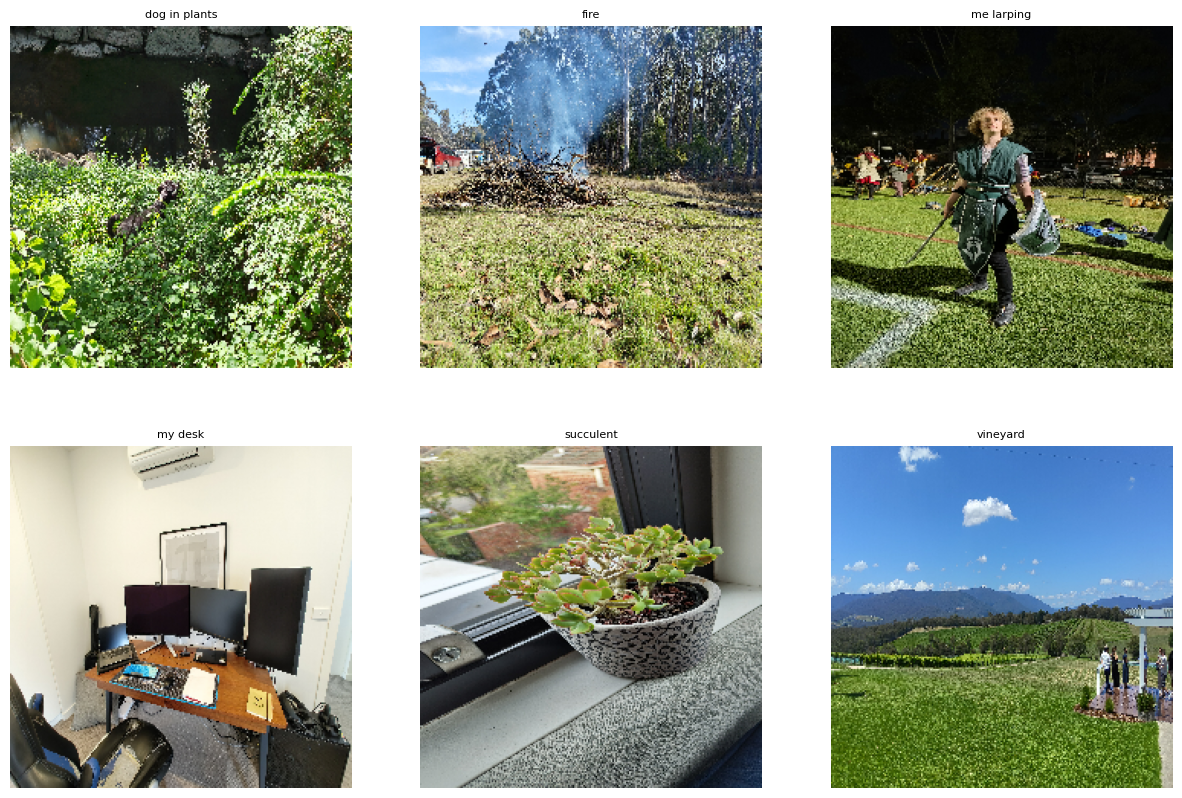

In [ ]:
dogInPlants = getImage('customData/dog-in-plants.jpg')
fire = getImage('customData/fire.jpg')
meLarping = getImage('customData/me-larping.jpg')
myDesk = getImage('customData/my-desk.jpg')
succulent = getImage('customData/succulent.jpg')
vineyard = getImage('customData/vineyard.jpg')

plt.figure(figsize=(15, 10)) 

plt.subplot(2, 3, 1)
plt.imshow(dogInPlants)
plt.title('dog in plants', fontsize=8)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(fire)
plt.title('fire', fontsize=8)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(meLarping)
plt.title('me larping', fontsize=8)
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(myDesk)
plt.title('my desk', fontsize=8)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(succulent)
plt.title('succulent', fontsize=8)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(vineyard)
plt.title('vineyard', fontsize=8)
plt.axis('off')

plt.show()

For each image I decided to provide 3 descriptions, an accurate one, an inaccurate one, and a semi accurate or simple one.  

### The good 
The model was able to with a reasonably high certainty identify my dog even though he was partially hidden by the sourounding plants and even though there was a river in the picture is correctly identified that there was no fish visible in the photo. 
Surprisingly the model with a very strong confidence identified the photo of me dressed in my fantasy LARPing costume, I had expected this to be a weak point because of my distinctive costume and the niche hobby.
The photos of my desk were fairly easy to predict because how common the objects in the image are and this is reflected in the good results.

### The bad
The model completely failed to identify the fire in the picture this is partly due to the fact that the fire is rather small compared to the size of the branches its attached to but still the smoke is a clear give away that a better model should be able to pick up on. 
The model did predict that the photo of my pot plant was a plant but it was also 75% sure that the photo contained "people celebrating at a birthday party" I don't have much of an explanation as to why these 2 things could get confused for each other.

### The ugly
The model made no clear judgment as to what the vineyard was and this is likely due to the lack of vineyards in the training data.

### Conclusion

Over all the model was able to generalize to recognize many different scenes with different objects in them but it has clear limitation and categorically failed to recognize certain environments. 
In the future I believe that a larger more diverse dataset could vastly improve the performance on some tasks such as the vineyard image I had.

In [68]:
def predictionWrapper(image, hypo):
	tokenizedText = tf.convert_to_tensor(
		tf.keras.preprocessing.sequence.pad_sequences(
			[[vocabIndex[word] for word in hypo.split()]], 
			maxlen=maxLen
			)[0]
		)
	tokenizedText.set_shape([maxLen])
		
	x = tf.data.Dataset.from_tensors({'image': [image], 'text': [tokenizedText]})
	return (1 - model.predict(x, verbose=0)[0][0]) * 100

print('Dog in plants predictions')
print(f'Accurate: {predictionWrapper(dogInPlants, "a dog in the bush next to a river"):2.2f}')
print(f'Inaccurate: {predictionWrapper(dogInPlants, "a large fish swimming down stream"):2.2f}')
print(f'Semi-accurate: {predictionWrapper(dogInPlants, "a dog"):2.2f}')

print('Fire predictions')
print(f'Accurate: {predictionWrapper(fire, "a large fire on a country property"):2.2f}')
print(f'Inaccurate: {predictionWrapper(fire, "a fireplace inside an old home"):2.2f}')
print(f'Semi-accurate: {predictionWrapper(fire, "a pile of tree branches"):2.2f}')

print('Me larping')
print(f'Accurate: {predictionWrapper(meLarping, "a person dressed up in a costume"):2.2f}')
print(f'Inaccurate: {predictionWrapper(meLarping, "a cat sleeping on a large bed"):2.2f}')
print(f'Semi-accurate: {predictionWrapper(meLarping, "me having fun"):2.2f}')

print('My desk')
print(f'Accurate: {predictionWrapper(myDesk, "a wooden desk with multiple displays"):2.2f}')
print(f'Inaccurate: {predictionWrapper(myDesk, "a hiker out in the forest"):2.2f}')
print(f'Semi-accurate: {predictionWrapper(myDesk, "my work space"):2.2f}')

print('Succulent')
print(f'Accurate: {predictionWrapper(succulent, "a potted plant on a window still"):2.2f}')
print(f'Inaccurate: {predictionWrapper(succulent, "people celebrating at a birthday party"):2.2f}')
print(f'Semi-accurate: {predictionWrapper(succulent, "a plant"):2.2f}')

print('Vineyard')
print(f'Accurate: {predictionWrapper(vineyard, "a sunny day on a farm with people enjoying the view of hills in the distance"):2.2f}')
print(f'Inaccurate: {predictionWrapper(vineyard, "a modern apartment building next to a park"):2.2f}')
print(f'Semi-accurate: {predictionWrapper(vineyard, "a wine farm"):2.2f}')

Dog in plants predictions
Accurate: 64.09
Inaccurate: 12.29
Semi-accurate: 77.54
Fire predictions
Accurate: 22.89
Inaccurate: 3.62
Semi-accurate: 55.88
Me larping
Accurate: 91.90
Inaccurate: 0.21
Semi-accurate: 71.36
My desk
Accurate: 73.56
Inaccurate: 32.33
Semi-accurate: 68.73
Succulent
Accurate: 60.33
Inaccurate: 74.67
Semi-accurate: 92.73
Vineyard
Accurate: 42.40
Inaccurate: 49.57
Semi-accurate: 51.78


# Final predictions 

In [ ]:
import csv

dataDictBlindTest = {}

with open("./A2_test_v3_final.jsonl", "r") as jsonFile:
	for line in jsonFile:
		loadedLine = json.loads(line)
		if loadedLine["Image_ID"] not in dataDictBlindTest:
			dataDictBlindTest[loadedLine["Image_ID"]] = []


		dataDictBlindTest[loadedLine["Image_ID"]].append(loadedLine["Hypothesis"])

hypoRaw = []
X1arrayBlindTest = []
X2arrayBlindTest = []

for key, hypos in dataDictBlindTest.items():
	img = f'./A2_test_Images/{key}.jpg'

	for hypo in hypos:
		hypoRaw.append(hypo)

		hypo = [''.join(char for char in word if char.isalnum()) for word in hypo.lower().split()]
		hypo = [vocabIndex.get(word, 0) for word in hypo]
		hypo = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([hypo], maxlen=maxLen)[0])
		hypo.set_shape([maxLen])

		X1arrayBlindTest.append(img)
		X2arrayBlindTest.append(hypo)

def getImageWrapperNoY(x):
	img = tf.py_function(func=getImage, inp=[x['image']], Tout=tf.float32)
	img.set_shape([imageRes, imageRes, imageChannels])

	x['image'] = img 
	return x

X1NumpyBlindTest = np.array(X1arrayBlindTest)
X2NumpyBlindTest = np.array(X2arrayBlindTest, dtype='uint16')

datasetBlindTest = tf.data.Dataset.from_tensor_slices({'image': X1NumpyBlindTest, 'text': X2NumpyBlindTest}) 
datasetBlindTest = datasetBlindTest.map(getImageWrapperNoY, num_parallel_calls=8)
datasetBlindTest = datasetBlindTest.batch(batchSize)

predictions = model.predict(datasetBlindTest)

results = []

for i in range(len(predictions)):
	pred = round(predictions[i][0])
	results.append({
		'Image_ID': X1arrayBlindTest[i],
		'Label': labelTuple[pred],
		'Hypothesis': hypoRaw[i]
	}) 

with open('s13947135_predictions_a2.csv', 'w') as csvfile:
    fieldnames = ['imageID','label',]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

 34/120 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step